In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Dense, LSTM

In [3]:
# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 25
epochs = 25

# number of elements ahead that are used to make the prediction
lahead = 1

In [4]:
def gen_cosine_amp(amp=100, period=1000, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(2 * np.pi * idx / period)
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos

In [5]:
print('Generating Data...')
cos = gen_cosine_amp()
print('Input shape:', cos.shape)

Generating Data...
Input shape: (50000, 1, 1)


In [8]:
expected_output = np.zeros((len(cos), 1))
for i in range(len(cos) - lahead):
    expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

In [9]:
print('Output shape:', expected_output.shape)

Output shape: (50000, 1)


In [10]:
print('Creating Model...')
model = Sequential()
model.add(LSTM(50,
               input_shape=(tsteps, 1),
               batch_size=batch_size,
               return_sequences=True,
               stateful=True))
model.add(LSTM(50,
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

Creating Model...


In [11]:
print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)

    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in cos.
    # Each of these series are offset by one step and can be
    # extracted with cos[i::batch_size].

    model.fit(cos, expected_output,
              batch_size=batch_size,
              epochs=1,
              verbose=1,
              shuffle=False)
    model.reset_states()


Training
Epoch 0 / 25
Epoch 1/1
50000/50000 [==============================] - 3s - loss: 342.1425     
Epoch 1 / 25
Epoch 1/1
50000/50000 [==============================] - 3s - loss: 156.7971     
Epoch 2 / 25
Epoch 1/1
50000/50000 [==============================] - 3s - loss: 121.5669     
Epoch 3 / 25
Epoch 1/1
50000/50000 [==============================] - 3s - loss: 68.3335     
Epoch 4 / 25
Epoch 1/1
50000/50000 [==============================] - 3s - loss: 49.0514     
Epoch 5 / 25
Epoch 1/1
50000/50000 [==============================] - 3s - loss: 38.8398     
Epoch 6 / 25
Epoch 1/1
50000/50000 [==============================] - 3s - loss: 26.9672     
Epoch 7 / 25
Epoch 1/1
50000/50000 [==============================] - 3s - loss: 20.7457     
Epoch 8 / 25
Epoch 1/1
50000/50000 [==============================] - 3s - loss: 19.2910     
Epoch 9 / 25
Epoch 1/1
50000/50000 [==============================] - 3s - loss: 17.8871     
Epoch 10 / 25
Epoch 1/1
50000/50000 [===========

Predicting
Plotting Results


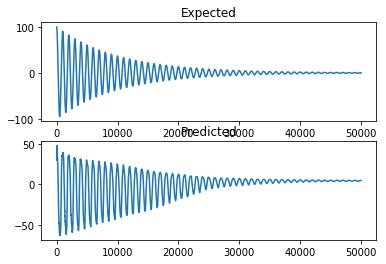

In [12]:
print('Predicting')
predicted_output = model.predict(cos, batch_size=batch_size)

print('Plotting Results')
plt.subplot(2, 1, 1)
plt.plot(expected_output)
plt.title('Expected')
plt.subplot(2, 1, 2)
plt.plot(predicted_output)
plt.title('Predicted')
plt.show()